In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Поскольку у меня старая версия python, и на данный момент нет возможности установить новую, пришлось переконвертировать файл xslx в xls, так как библиотека, считывающая расширение xslx не работает на моей версии,
по той же причине пришлось преобразовать строки в столбцах с русским текстом, используя кодировку UTF-8.

In [2]:
df = pd.read_excel('data.xls')

In [3]:
df.dtypes

client_id         float64
sum               float64
status             object
sale               object
new/current        object
Unnamed: 5        float64
document           object
receiving_date     object
dtype: object

In [4]:
df['status'] = df['status'].apply(lambda x: x.encode('utf-8') if not isinstance(x, float) else x)
df['sale'] = df['sale'].apply(lambda x: x.encode('utf-8') if not isinstance(x, float) else x)
df['new/current'] = df['new/current'].apply(lambda x: x.encode('utf-8') if not isinstance(x, float) else x)
df['document'] = df['document'].apply(lambda x: x.encode('utf-8') if not isinstance(x, float) else x)

In [5]:
df['receiving_date'] = pd.to_datetime(df['receiving_date'], errors='coerce')

In [6]:
df['Unnamed: 5'].isna().value_counts()

True    730
Name: Unnamed: 5, dtype: int64

In [7]:
del df['Unnamed: 5']

In [8]:
df.status.value_counts()

ОПЛАЧЕНО         622
ПРОСРОЧЕНО        52
В РАБОТЕ          44
НА ПОДПИСАНИИ      5
Сентябрь 2021      1
ВНУТРЕННИЙ         1
Октябрь 2021       1
Август 2021        1
Май 2021           1
Июль 2021          1
Июнь 2021          1
Name: status, dtype: int64

In [9]:
indMay = df.loc[df['status'] == 'Май 2021'].index[0]
indJun = df.loc[df['status'] == 'Июнь 2021'].index[0]
indJul = df.loc[df['status'] == 'Июль 2021'].index[0]
indAug = df.loc[df['status'] == 'Август 2021'].index[0]
indSep = df.loc[df['status'] == 'Сентябрь 2021'].index[0]
indOct = df.loc[df['status'] == 'Октябрь 2021'].index[0]

In [10]:
df.head()

,client_id,sum,status,sale,new/current,document,receiving_date
0,NaN,NaN,Май 2021,NaN,NaN,NaN,NaT
1,6.0,11693.7,ВНУТРЕННИЙ,-,-,-,NaT
2,14.0,5452.7,ОПЛАЧЕНО,Петрова,новая,оригинал,2021-07-26
3,15.0,13991.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08
4,16.0,719.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08


1) Вычислите общую выручку за июль 2021 по тем сделкам, приход денежных средств которых не просрочен.

In [11]:
df[indJul:indAug].loc[df['status'] != 'ПРОСРОЧЕНО']['sum'].sum().round(2)

859896.47

2) Как изменялась выручка компании за рассматриваемый период? Проиллюстрируйте графиком.

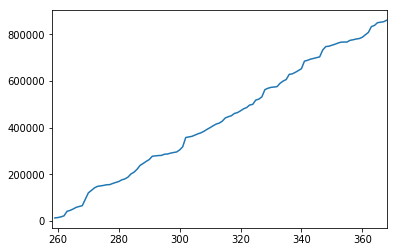

In [12]:
df[indJul:indAug].loc[df['status'] != 'ПРОСРОЧЕНО']['sum'].cumsum().plot()

3) Кто из менеджеров привлек для компании больше всего денежных средств в сентябре 2021?

In [13]:
df[indSep:indOct].groupby('sale', as_index=False).agg({'sum': sum}).sort_values('sum', ascending=False).head(1)

,sale,sum
6,Смирнов,221525.7


4) Какой тип сделок (новая/текущая) был преобладающим в октябре 2021?

In [14]:
df[indOct:]['new/current'].value_counts()

текущая    99
новая      36
Name: new/current, dtype: int64

5) Сколько оригиналов договора по майским сделкам было получено в июне 2021?

In [15]:
df[indMay:indJul].loc[(df['document'] == 'оригинал') & (df['receiving_date'].dt.month == 6)].shape[0]

76

За каждую заключенную сделку менеджер получает бонус, который рассчитывается следующим образом.
1) За новые сделки менеджер получает 7 % от суммы, при условии, что статус оплаты «ОПЛАЧЕНО», а также имеется оригинал подписанного договора с клиентом (в рассматриваемом месяце).
2) За текущие сделки менеджер получает 5 % от суммы, если она больше 10 тыс., и 3 % от суммы, если меньше. При этом статус оплаты может быть любым, кроме «ПРОСРОЧЕНО», а также необходимо наличие оригинала подписанного договора с клиентом (в рассматриваемом месяце).
Бонусы по сделкам, оригиналы для которых приходят позже рассматриваемого месяца, считаются остатком на следующий период, который выплачивается по мере прихода оригиналов. Вычислите остаток каждого из менеджеров на 01.07.2021.

In [16]:
df1 = df[indMay:indJul]

In [17]:
df1 = df1.loc[(df1['document'] == 'оригинал') & (~df1['receiving_date'].dt.month.isin([5,6]))]

In [18]:
dfNew = df1.loc[(df1['status'] == 'ОПЛАЧЕНО') & (df1['new/current'] == 'новая')] \
   .groupby('sale', as_index=False).agg({'sum': sum})

In [19]:
dfNew['bonus'] = dfNew['sum'].mul(0.07)
del dfNew['sum']

In [20]:
dfNew

,sale,bonus
0,Васильев,187.509
1,Петрова,2877.448
2,Селиванов,4336.913
3,Смирнов,213.759
4,Филимонова,727.468


In [21]:
dfCurrent = df1.loc[(df1['status'] != 'ПРОСРОЧЕНО') & (df1['new/current'] == 'текущая')]

In [22]:
dfCurrent['bonus'] = dfCurrent['sum'].apply(lambda x: x * 0.05 if x > 10000 else x * 0.03)

/Users/yuri/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
dfCurrent =  dfCurrent.groupby('sale', as_index=False).agg({'bonus': sum})

In [24]:
dfCurrent

,sale,bonus
0,Андреев,3945.8297
1,Васильев,849.5400
2,Иванов,5991.4520
3,Кузнецова,4496.9501
4,Петрова,7893.2994
5,Селиванов,960.7770
6,Смирнов,6216.5060
7,Соколов,269.2110
8,Филимонова,1590.4899


In [25]:
dfRemainBonus = pd.merge(dfNew, dfCurrent, on='sale', how='outer')
dfRemainBonus['total_bonus'] = dfRemainBonus['bonus_x'].fillna(0) + dfRemainBonus['bonus_y'].fillna(0)
dfRemainBonus = dfRemainBonus.drop(columns=['bonus_x', 'bonus_y'])
dfRemainBonus['total_bonus'] = dfRemainBonus['total_bonus'].round(2)

Остаток каждого из менеджеров на 01.07.2021 :

In [26]:
dfRemainBonus

,sale,total_bonus
0,Васильев,1037.05
1,Петрова,10770.75
2,Селиванов,5297.69
3,Смирнов,6430.26
4,Филимонова,2317.96
5,Андреев,3945.83
6,Иванов,5991.45
7,Кузнецова,4496.95
8,Соколов,269.21
